In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from analysis.datasets import load_entsoe
from analysis.splits import to_train_validation_test_data
from analysis.transformations import scale_power_data
from tabpfn import TabPFNRegressor
from analysis.transformations import add_interval_index, add_lagged_features
from torchinfo import summary
from analysis.TabPFN_copy import evaluate
import torch
import seaborn as sns
from analysis.TabPFN_copy import fit_tail_distribution, plot_cdf_pdf_dynamic, plot_pdf_from_logits
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Info

### model.predict:
The `predict` method returns a dictionary containing different types of outputs based on the `output_type` parameter:
1. `main`
- a dictionary with key statistical outputs (mean, median, mode, quantiles)

2. `full`
- Includes everything from "main", plus
    - logits: returns 5000 log probabilities per prediction. This is better than only quantiles as they represent the complete set of 5000 raw probabilities and quantiles provide only specific summary points (e.g. the 0.1, 0.2, ..., 0.9 quantiles).These 5000 values can be used to obtain a cdf
    - criterion: A function to compute various probability-related metrics.


### Criterion methods
- `probs_val["criterion"].borders` returns the borders appropriate for the training data used and not the standard borders from TabPFN
- `probs_val["criterion"].forward` returns the nll (In the bar_distribution.py module: class "bar_distribution.py")
- `probs_val["criterion"].cdf`
- `probs_val["criterion"].pdf`


### Two Ways to Calculate CRPS and NLL

There are two main approaches to computing the Continuous Ranked Probability Score (CRPS) and Negative Log-Likelihood (NLL):

#### 1. Using Logits (5000 Bins)
- For each validation data point, we have **5000 logits** and **5000 bin borders**.
- These logits represent the probability distribution in detail.
- We compute CRPS and NLL directly from these values.

#### 2. Using 10 Deciles
- Instead of using all 5000 bins, we only have **10 deciles** (the 10th, 20th, ..., 90th percentiles).
- From these deciles, we reconstruct the **Cumulative Distribution Function (CDF)** and **Probability Density Function (PDF)**.
- We then compute CRPS (via integration) and NLL (by taking the logarithm of the PDF at the true values).

The first method provides a more detailed probability distribution, while the second is a summarized approximation.


# Train TabPFN with limited input

In [2]:
n = 10
n1 = 1000
#feature_columns = ['power_t-96']
feature_columns = ['ws_10m_loc_mean', 'ws_100m_loc_mean']
target_column='power'
quantiles_custom = np.arange(0.1, 1, 0.1) # the quantiles to return at those probabilities


entsoe = load_entsoe()
entsoe = scale_power_data(entsoe)
entsoe = add_lagged_features(entsoe)
entsoe = add_interval_index(entsoe)
entsoe.dropna(inplace=True)

train, validation, test = to_train_validation_test_data(entsoe, "2016-03-31 23:45:00", "2016-06-30 23:45:00")
X_train, y_train = train[feature_columns], train[target_column]
X_validation, y_validation = validation[feature_columns], validation[target_column]

X_train_lim = X_train.head(n1)
y_train_lim = y_train.head(n1)

X_val_lim = X_validation.head(n)
y_val_lim = y_validation.head(n)
y_val_lim_torch = torch.tensor(y_val_lim, dtype=torch.float32)

#model = TabPFNRegressor(device='auto', ignore_pretraining_limits=True, fit_mode='low_memory', random_state=42)
model = TabPFNRegressor(device='auto', fit_mode='low_memory', random_state=42)
model.fit(X_train_lim, y_train_lim)

probs_val = model.predict(X_val_lim, output_type="full", quantiles=quantiles_custom)
logits = probs_val["logits"]
borders_new = probs_val["criterion"].borders # returns borders appropriate for the training data used and not the standard borders from TabPFN
all_quantiles = np.array(probs_val["quantiles"])

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)
# of training observations: 8640 | 2.74%
# of validation observations: 8736 | 2.77%
# of test observations: 298173 | 94.49%


C:\Users\Minu\AppData\Local\Temp\ipykernel_16304\3769669482.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val_lim_torch = torch.tensor(y_val_lim, dtype=torch.float32)
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151

In [3]:
borders_new

tensor([-73.6172, -22.0029, -19.3049,  ...,  16.4085,  19.0756,  65.1648])

## Compute crps from logits and bins at once using PyTorch. Given that:
- You have a batch of 𝑁 rows
- Each row has 5000 logits.
- Each row has one corresponding 𝑦 value.
- The bin boundaries are fixed across rows.

In [ ]:
def compute_crps_pytorch(logits, bin_edges, y_values):
    """
    Computes the CRPS for multiple rows of logits and corresponding y-values using PyTorch.

    Args:
        logits: Tensor of shape (N, 5000) - unnormalized logits for each row.
        bin_edges: Tensor of shape (5001,) - common bin edges for all rows.
        y_values: Tensor of shape (N,) - target values for each row.

    Returns:
        Tensor of shape (N,) containing the CRPS values for each row.
    """

    # Convert logits to probabilities using softmax
    probs = torch.softmax(logits, dim=1)  # (N, 5000)

    # Compute CDF (cumulative sum of probabilities)
    cdf = torch.cumsum(probs, dim=1)  # (N, 5000)

    # Compute the indicator function (1 if bin edge >= y, else 0)
    # We need to compare each y_value with bin_edges and broadcast correctly
    indicators = (bin_edges[1:].unsqueeze(0) >= y_values.unsqueeze(1)).float()  # (N, 5000)

    # Step 4: Compute bin widths
    bin_widths = (bin_edges[1:] - bin_edges[:-1]).unsqueeze(0)  # (1, 5000)

    # Step 5: Compute CRPS integral for each row
    crps = torch.sum((cdf - indicators) ** 2 * bin_widths, dim=1)  # (N,)

    return crps


In [ ]:
y_values = torch.tensor(y_val_lim, dtype=torch.float32)
crps_values_torch = compute_crps_pytorch(logits, borders_new, y_values)
print("CRPS shape:", crps_values_torch.shape)  # Should be (N,)
print("First few CRPS values:", crps_values_torch)

output for 1000 training, 10 predict

CRPS shape: torch.Size([10])
First few CRPS values: tensor([0.2449, 0.3318, 0.3937, 0.3613, 0.3199, 0.2840, 0.2493, 0.3083, 0.3252, 0.2212])

## Compute nll using the inbuild forward method in TabPFN

In [ ]:
#probs_val["criterion"].forward(logits, torch.tensor(y_val_lim, dtype=torch.float32))
nll_torch = probs_val["criterion"].forward(logits, y_val_lim_torch)

## Compute crps, nll using the interpolated functions with 10 quantiles

In [ ]:
probabilities = quantiles_custom
yt = entsoe["power"]
#probabilities_10= np.array([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
quantile_10 = np.percentile(yt, probabilities * 100)

# Fit left and right tails
mu_left_asym, sigma_left_asym = fit_tail_distribution(quantile_10[:2], probabilities[:2])
mu_right_asym, sigma_right_asym = fit_tail_distribution(quantile_10[-2:], probabilities[-2:])


# Initialize lists to store the results
crps_cdf_linear_a = []
crps_hybrid_cdf_a = []
crps_normal_a = []

nll_pdf_linear_a = []
nll_pdf_hybrid_a = []
nll_normal_a = []

for i in range(0, y_val_lim.shape[0]):
    quantile_i = all_quantiles[:, i]
    y_i = y_validation[i]
    
    # Modify this line to expect 6 values
    cdf_linear, hybrid_cdf, crps_normal, pdf_linear, pdf_hybrid, nll_normal = evaluate(quantile_i, probabilities, y_i, -20, 5, mu_left_asym, sigma_left_asym, mu_right_asym, sigma_right_asym)
    
    # Append the results to respective lists
    crps_cdf_linear_a.append(cdf_linear)
    crps_hybrid_cdf_a.append(hybrid_cdf)
    crps_normal_a.append(crps_normal)
    
    nll_pdf_linear_a.append(pdf_linear)
    nll_pdf_hybrid_a.append(pdf_hybrid)
    nll_normal_a.append(nll_normal)


#print("crps linear", crps_cdf_linear_a)
#print("crps hybrid", crps_hybrid_cdf_a)
#print("crps normal", crps_normal_a)

#print("NLL linaer", nll_pdf_linear_a)
#print("NLL hybrid", nll_pdf_hybrid_a)
#print("NLL normal", nll_normal_a)

# Calculate and print the mean values
mean_crps_cdf_linear = np.mean(crps_cdf_linear_a)
mean_crps_hybrid_cdf_a = np.mean(crps_hybrid_cdf_a)
mean_crps_normal_a = np.mean(crps_normal_a)

mean_nll_pdf_linear_a = np.mean(nll_pdf_linear_a)
mean_nll_pdf_hybrid_a = np.mean(nll_pdf_hybrid_a)
mean_nll_normal_a = np.mean(nll_normal_a)

# Print the results
print(f"Mean CRPS for CDF Linear interpolation: {mean_crps_cdf_linear:.4f}")
print(f"Mean CRPS for Hybrid CDF interpolation: {mean_crps_hybrid_cdf_a:.4f}")
print(f"Mean CRPS for Normal distribution interpolation: {mean_crps_normal_a:.4f}")

print(f"Mean NLL for PDF Linear interpolation: {mean_nll_pdf_linear_a:.4f}")
print(f"Mean NLL for PDF Hybrid interpolation: {mean_nll_pdf_hybrid_a:.4f}")
print(f"Mean NLL for Normal distribution interpolation: {mean_nll_normal_a:.4f}")


## Compute crps from logits and bins at once using PyTorch. Given that:
- You have a batch of 𝑁 rows
- Each row has 5000 logits.
- Each row has one corresponding 𝑦 value.
- The bin boundaries are fixed across rows.

In [ ]:
def compute_crps_pytorch(logits, bin_edges, y_values):
    """
    Computes the CRPS for multiple rows of logits and corresponding y-values using PyTorch.

    Args:
        logits: Tensor of shape (N, 5000) - unnormalized logits for each row.
        bin_edges: Tensor of shape (5001,) - common bin edges for all rows.
        y_values: Tensor of shape (N,) - target values for each row.

    Returns:
        Tensor of shape (N,) containing the CRPS values for each row.
    """

    # Convert logits to probabilities using softmax
    probs = torch.softmax(logits, dim=1)  # (N, 5000)

    # Compute CDF (cumulative sum of probabilities)
    cdf = torch.cumsum(probs, dim=1)  # (N, 5000)

    # Compute the indicator function (1 if bin edge >= y, else 0)
    # We need to compare each y_value with bin_edges and broadcast correctly
    indicators = (bin_edges[1:].unsqueeze(0) >= y_values.unsqueeze(1)).float()  # (N, 5000)

    # Step 4: Compute bin widths
    bin_widths = (bin_edges[1:] - bin_edges[:-1]).unsqueeze(0)  # (1, 5000)

    # Step 5: Compute CRPS integral for each row
    crps = torch.sum((cdf - indicators) ** 2 * bin_widths, dim=1)  # (N,)

    return crps


In [ ]:
y_values = torch.tensor(y_val_lim, dtype=torch.float32)
crps_values_torch = compute_crps_pytorch(logits, borders_new, y_values)
print("CRPS shape:", crps_values_torch.shape)  # Should be (N,)
print("First few CRPS values:", crps_values_torch)

output for 1000 training, 10 predict

CRPS shape: torch.Size([10])
First few CRPS values: tensor([0.2449, 0.3318, 0.3937, 0.3613, 0.3199, 0.2840, 0.2493, 0.3083, 0.3252, 0.2212])

## Compute nll using the inbuild forward method in TabPFN

In [ ]:
#probs_val["criterion"].forward(logits, torch.tensor(y_val_lim, dtype=torch.float32))
nll_torch = probs_val["criterion"].forward(logits, y_val_lim_torch)

## Compute crps, nll using the interpolated functions with 10 quantiles

In [ ]:
probabilities = quantiles_custom
yt = entsoe["power"]
#probabilities_10= np.array([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
quantile_10 = np.percentile(yt, probabilities * 100)

# Fit left and right tails
mu_left_asym, sigma_left_asym = fit_tail_distribution(quantile_10[:2], probabilities[:2])
mu_right_asym, sigma_right_asym = fit_tail_distribution(quantile_10[-2:], probabilities[-2:])


# Initialize lists to store the results
crps_cdf_linear_a = []
crps_hybrid_cdf_a = []
crps_normal_a = []

nll_pdf_linear_a = []
nll_pdf_hybrid_a = []
nll_normal_a = []

for i in range(0, y_val_lim.shape[0]):
    quantile_i = all_quantiles[:, i]
    y_i = y_validation[i]
    
    # Modify this line to expect 6 values
    cdf_linear, hybrid_cdf, crps_normal, pdf_linear, pdf_hybrid, nll_normal = evaluate(quantile_i, probabilities, y_i, -20, 5, mu_left_asym, sigma_left_asym, mu_right_asym, sigma_right_asym)
    
    # Append the results to respective lists
    crps_cdf_linear_a.append(cdf_linear)
    crps_hybrid_cdf_a.append(hybrid_cdf)
    crps_normal_a.append(crps_normal)
    
    nll_pdf_linear_a.append(pdf_linear)
    nll_pdf_hybrid_a.append(pdf_hybrid)
    nll_normal_a.append(nll_normal)


#print("crps linear", crps_cdf_linear_a)
#print("crps hybrid", crps_hybrid_cdf_a)
#print("crps normal", crps_normal_a)

#print("NLL linaer", nll_pdf_linear_a)
#print("NLL hybrid", nll_pdf_hybrid_a)
#print("NLL normal", nll_normal_a)

# Calculate and print the mean values
mean_crps_cdf_linear = np.mean(crps_cdf_linear_a)
mean_crps_hybrid_cdf_a = np.mean(crps_hybrid_cdf_a)
mean_crps_normal_a = np.mean(crps_normal_a)

mean_nll_pdf_linear_a = np.mean(nll_pdf_linear_a)
mean_nll_pdf_hybrid_a = np.mean(nll_pdf_hybrid_a)
mean_nll_normal_a = np.mean(nll_normal_a)

# Print the results
print(f"Mean CRPS for CDF Linear interpolation: {mean_crps_cdf_linear:.4f}")
print(f"Mean CRPS for Hybrid CDF interpolation: {mean_crps_hybrid_cdf_a:.4f}")
print(f"Mean CRPS for Normal distribution interpolation: {mean_crps_normal_a:.4f}")

print(f"Mean NLL for PDF Linear interpolation: {mean_nll_pdf_linear_a:.4f}")
print(f"Mean NLL for PDF Hybrid interpolation: {mean_nll_pdf_hybrid_a:.4f}")
print(f"Mean NLL for Normal distribution interpolation: {mean_nll_normal_a:.4f}")


## Test CRPS, NLL output against interpolated cdf, pdf from 10 deciles from TabPFN

In [ ]:
data = {
    'CRPS Linear': crps_cdf_linear_a,
    'CRPS Hybrid': crps_hybrid_cdf_a,
    'CRPS Normal': crps_normal_a,
    #'CRPS (5000 quantiles)': crps_values[0:10],
    'CRPS (5000 quantiles)': crps_values_torch,
    'NLL Linear': nll_pdf_linear_a,
    'NLL Hybrid': nll_pdf_hybrid_a,
    'NLL Normal': nll_normal_a,
    #'NLL (5000 quantiles)': probs_val["criterion"].forward(logits[:10,:], torch.tensor(y_validation.head(10), dtype=torch.float32)),
    'NLL (5000 quantiles)': nll_torch,
    'y values': torch.tensor(y_validation.head(10)),
    #'first quantile': all_quantiles[0,:],
    #'last quantile': all_quantiles[-1,:]

}

# Create DataFrame
df = pd.DataFrame(data)
df = df.round(8)
df

# Train TabPFN with full 3 months input

In [2]:
feature_columns = ['ws_10m_loc_mean', 'ws_100m_loc_mean']
target_column='power'
quantiles_custom = np.arange(0.1, 1, 0.1) # the quantiles to return at those probabilities
probabilities = quantiles_custom

entsoe = load_entsoe()
entsoe = scale_power_data(entsoe)
entsoe = add_lagged_features(entsoe)
entsoe = add_interval_index(entsoe)
entsoe.dropna(inplace=True)

Data loaded and transformed successfully. Shape of DataFrame: (78912, 22)


In [3]:
train, validation, test = to_train_validation_test_data(entsoe, "2016-03-31 23:45:00", "2016-06-30 23:45:00")
X_train, y_train = train[feature_columns], train[target_column]
X_validation, y_validation = validation[feature_columns], validation[target_column]

X_train_full = X_train
y_train_full = y_train

X_val_full = X_validation
y_val_full = y_validation
y_val_full_torch_2 = torch.tensor(y_val_full, dtype=torch.float32)

# of training observations: 8640 | 2.74%
# of validation observations: 8736 | 2.77%
# of test observations: 298173 | 94.49%


C:\Users\Minu\AppData\Local\Temp\ipykernel_10068\341682646.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_val_full_torch_2 = torch.tensor(y_val_full, dtype=torch.float32)


In [4]:
#model = TabPFNRegressor(device='auto', ignore_pretraining_limits=True, fit_mode='low_memory', random_state=42)
model = TabPFNRegressor(device='auto', fit_mode='low_memory', random_state=42)
model.fit(X_train_full, y_train_full)

c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


TabPFNRegressor(fit_mode='low_memory', random_state=42)

In [5]:
probs_val = model.predict(X_val_full, output_type="full", quantiles=quantiles_custom)
logits_2 = probs_val["logits"]
borders_new_2 = probs_val["criterion"].borders # returns borders appropriate for the training data used and not the standard borders from TabPFN
all_quantiles_2 = np.array(probs_val["quantiles"])

c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Minu\Documents\master-thesis\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [6]:
borders_new_2

tensor([-97.1042, -28.6615, -25.0839,  ...,  22.2734,  25.8102,  86.9263])

## Compute crps from logits and bins at once using PyTorch. Given that:
- You have a batch of 𝑁 rows
- Each row has 5000 logits.
- Each row has one corresponding 𝑦 value.
- The bin boundaries are fixed across rows.

In [ ]:
def compute_crps_pytorch(logits, bin_edges, y_values):
    """
    Computes the CRPS for multiple rows of logits and corresponding y-values using PyTorch.

    Args:
        logits: Tensor of shape (N, 5000) - unnormalized logits for each row.
        bin_edges: Tensor of shape (5001,) - common bin edges for all rows.
        y_values: Tensor of shape (N,) - target values for each row.

    Returns:
        Tensor of shape (N,) containing the CRPS values for each row.
    """

    # Convert logits to probabilities using softmax
    probs = torch.softmax(logits, dim=1)  # (N, 5000)

    # Compute CDF (cumulative sum of probabilities)
    cdf = torch.cumsum(probs, dim=1)  # (N, 5000)

    # Compute the indicator function (1 if bin edge >= y, else 0)
    # We need to compare each y_value with bin_edges and broadcast correctly
    indicators = (bin_edges[1:].unsqueeze(0) >= y_values.unsqueeze(1)).float()  # (N, 5000)

    # Step 4: Compute bin widths
    bin_widths = (bin_edges[1:] - bin_edges[:-1]).unsqueeze(0)  # (1, 5000)

    # Step 5: Compute CRPS integral for each row
    crps = torch.sum((cdf - indicators) ** 2 * bin_widths, dim=1)  # (N,)

    return crps


In [18]:
pd.DataFrame(logits_2)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,-17.444101,-18.717710,-19.904541,-20.106821,-20.383646,-20.433794,-20.753872,-20.789223,-20.950943,-20.954708,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.802319
1,-18.846626,-19.415409,-20.932524,-21.408855,-21.577137,-21.836687,-22.196836,-22.149126,-22.388521,-22.397434,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.944289
2,-20.223282,-20.021959,-21.696226,-22.436361,-22.458538,-22.947321,-23.388056,-23.196247,-23.554127,-23.554781,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.862944
3,-20.855036,-20.497683,-22.109495,-22.899035,-22.889559,-23.403170,-23.877344,-23.624632,-24.011829,-24.031548,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-13.961384
4,-21.121668,-20.860361,-22.341322,-23.116552,-23.070498,-23.566345,-24.055202,-23.777763,-24.160465,-24.198326,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.109804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8731,-21.117031,-21.671505,-22.679270,-23.148352,-23.173695,-23.538136,-23.911282,-23.737398,-24.045086,-24.081507,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.130007
8732,-21.154364,-21.788448,-22.766130,-23.158630,-23.242376,-23.571962,-23.925117,-23.800238,-24.077635,-24.115520,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.384240
8733,-20.800245,-21.431351,-22.593248,-22.961729,-23.076843,-23.408779,-23.754864,-23.669836,-23.940401,-23.998047,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.296133
8734,-21.137726,-21.811640,-22.997126,-23.343077,-23.499756,-23.782120,-24.131496,-24.143183,-24.307531,-24.372849,...,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-14.140263


In [ ]:
crps_values_torch_2 = compute_crps_pytorch(logits_2, borders_new_2, y_val_full_torch_2)
print("CRPS shape:", crps_values_torch_2.shape)  # Should be (N,)
print("First few CRPS values:", crps_values_torch_2)

## Compute nll using the inbuild forward method in TabPFN

In [ ]:
#probs_val["criterion"].forward(logits, torch.tensor(y_val_lim, dtype=torch.float32))
nll_torch_2 = probs_val_2["criterion"].forward(logits_2, y_val_full_torch_2)

## Compute crps, nll using the interpolated functions with 10 quantiles

In [ ]:
probabilities = quantiles_custom
yt = entsoe["power"]
quantile_10 = np.percentile(yt, probabilities * 100)

# Fit left and right tails
mu_left_asym, sigma_left_asym = fit_tail_distribution(quantile_10[:2], probabilities[:2])
mu_right_asym, sigma_right_asym = fit_tail_distribution(quantile_10[-2:], probabilities[-2:])

#probabilities_10= np.array([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
quantile_10 = np.percentile(yt, probabilities * 100)

# Initialize lists to store the results
crps_cdf_linear_a_full = []
crps_hybrid_cdf_a_full = []
crps_normal_a_full = []

nll_pdf_linear_a_full = []
nll_pdf_hybrid_a_full = []
nll_normal_a_full = []

for i in range(0, y_val_full.shape[0]):
    quantile_i = all_quantiles_2[:, i]
    y_i = y_val_full[i]
    
    # Modify this line to expect 6 values
    cdf_linear, hybrid_cdf, crps_normal, pdf_linear, pdf_hybrid, nll_normal = evaluate(quantile_i, probabilities, y_i, -20, 5, mu_left_asym, sigma_left_asym, mu_right_asym, sigma_right_asym)
    
    # Append the results to respective lists
    crps_cdf_linear_a_full.append(cdf_linear)
    crps_hybrid_cdf_a_full.append(hybrid_cdf)
    crps_normal_a_full.append(crps_normal)
    
    nll_pdf_linear_a_full.append(pdf_linear)
    nll_pdf_hybrid_a_full.append(pdf_hybrid)
    nll_normal_a_full.append(nll_normal)


#print("crps linear", crps_cdf_linear_a)
#print("crps hybrid", crps_hybrid_cdf_a)
#print("crps normal", crps_normal_a)

#print("NLL linaer", nll_pdf_linear_a)
#print("NLL hybrid", nll_pdf_hybrid_a)
#print("NLL normal", nll_normal_a)

# Calculate and print the mean values
mean_crps_cdf_linear_full = np.mean(crps_cdf_linear_a_full)
mean_crps_hybrid_cdf_a_full = np.mean(crps_hybrid_cdf_a_full)
mean_crps_normal_a_full = np.mean(crps_normal_a_full)

mean_nll_pdf_linear_a_full = np.mean(nll_pdf_linear_a_full)
mean_nll_pdf_hybrid_a_full = np.mean(nll_pdf_hybrid_a_full)
mean_nll_normal_a_full = np.mean(nll_normal_a_full)

# Print the results
print(f"Mean CRPS for CDF Linear interpolation: {mean_crps_cdf_linear_full:.4f}")
print(f"Mean CRPS for Hybrid CDF interpolation: {mean_crps_hybrid_cdf_a_full:.4f}")
print(f"Mean CRPS for Normal distribution interpolation: {mean_crps_normal_a_full:.4f}")

print(f"Mean NLL for PDF Linear interpolation: {mean_nll_pdf_linear_a_full:.4f}")
print(f"Mean NLL for PDF Hybrid interpolation: {mean_nll_pdf_hybrid_a_full:.4f}")
print(f"Mean NLL for Normal distribution interpolation: {mean_nll_normal_a_full:.4f}")


## Test CRPS, NLL output against interpolated cdf, pdf from 10 deciles from TabPFN

In [ ]:
data_2 = {
    'CRPS Linear': crps_cdf_linear_a_full,
    'CRPS Hybrid': crps_hybrid_cdf_a_full,
    'CRPS Normal': crps_normal_a_full,
    #'CRPS (5000 quantiles)': crps_values[0:10],
    'CRPS (5000 quantiles)': crps_values_torch_2,
    'NLL Linear': nll_pdf_linear_a_full,
    'NLL Hybrid': nll_pdf_hybrid_a_full,
    'NLL Normal': nll_normal_a_full,
    #'NLL (5000 quantiles)': probs_val["criterion"].forward(logits[:10,:], torch.tensor(y_validation.head(10), dtype=torch.float32)),
    'NLL (5000 quantiles)': nll_torch_2,
    'y values': y_val_full_torch_2,
    #'first quantile': all_quantiles[0,:],
    #'last quantile': all_quantiles[-1,:]
}

# Create DataFrame
df_full = pd.DataFrame(data_2)
df_full = df_full.round(8)
df_full

# Determination of the parameters of the normal distribution describing the tails. Note: all y data is used i.e. it is assumed that all distribution y given x follow the same distribution in the left and right tails 

In [ ]:
# --- Fit Normal Distributions for Tails ---
from scipy.stats import norm
def fit_tail_distribution(quantiles, probabilities):
        """Fits a normal distribution to the given quantiles and associated probabilities."""
        z_scores = norm.ppf(probabilities)
        sigma = (quantiles[1] - quantiles[0]) / (z_scores[1] - z_scores[0])
        mu = quantiles[0] - sigma * z_scores[0]
        return mu, sigma


yt = entsoe["power"]
probabilities_10= np.array([0.1, 0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
quantile_10 = np.percentile(yt, probabilities_10 * 100)

# Fit left and right tails
mu_left, sigma_left = fit_tail_distribution(quantile_10[:2], probabilities_10[:2])
mu_right, sigma_right = fit_tail_distribution(quantile_10[-2:], probabilities_10[-2:])
sigma_left, sigma_right

df = pd.DataFrame(yt)
sns.histplot(df["power"], bins=100, kde=False, color='skyblue', stat='density', label='Data Histogram')
xmin, xmax = df['power'].min(), df['power'].max()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_left, sigma_left)
p2 = norm.pdf(x, mu_right, sigma_right)

plt.plot(x, p, 'r-', label=f'Normal Distribution\n$\mu={mu_left:.2f}$, $\sigma={sigma_left:.2f}$', color="b")
plt.plot(x, p2, 'r-', label=f'Normal Distribution\n$\mu={mu_right:.2f}$, $\sigma={sigma_right:.2f}$')
plt.yscale("log")
plt.legend()

plt.ylim(1e-4, 1)


In [ ]:
pd.DataFrame(all_quantiles_2)

In [ ]:
pd.DataFrame(all_quantiles_2[:,1])

In [ ]:
probabilities

In [ ]:
pd.DataFrame(all_quantiles_2)

In [ ]:
plot_cdf_pdf_dynamic(all_quantiles_2[:,5], probabilities, -10, 5, case=2, 
                     mu_left_asym=mu_left_asym, sigma_left_asym=sigma_left_asym, 
                     mu_right_asym=mu_right_asym, sigma_right_asym=sigma_right_asym)
print("---")
plot_cdf_pdf_dynamic(all_quantiles_2[:,5], probabilities, -10, 5, case=3, 
                     mu_left_asym=mu_left_asym, sigma_left_asym=sigma_left_asym, 
                     mu_right_asym=mu_right_asym, sigma_right_asym=sigma_right_asym)


In [ ]:
pd.DataFrame(all_quantiles_2[:,70], probabilities)

<Figure size 1100x600 with 0 Axes>

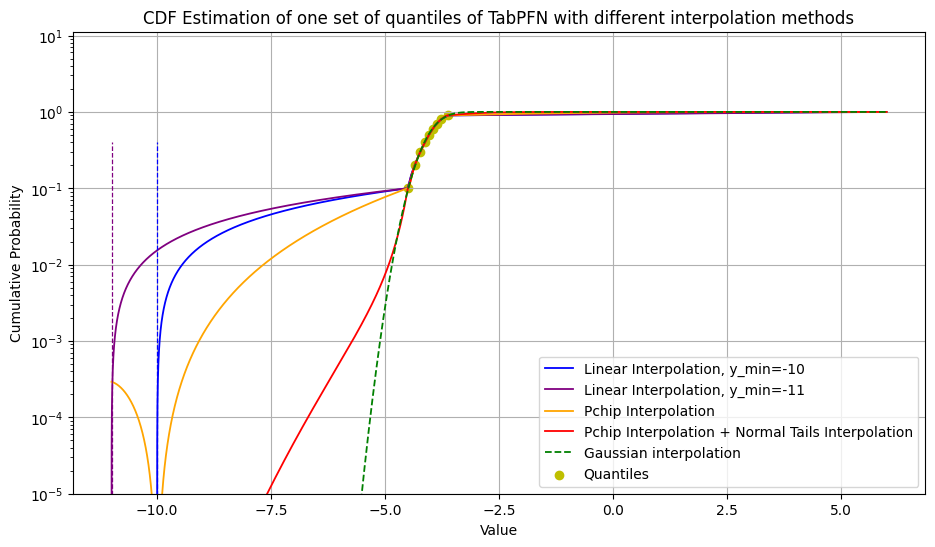

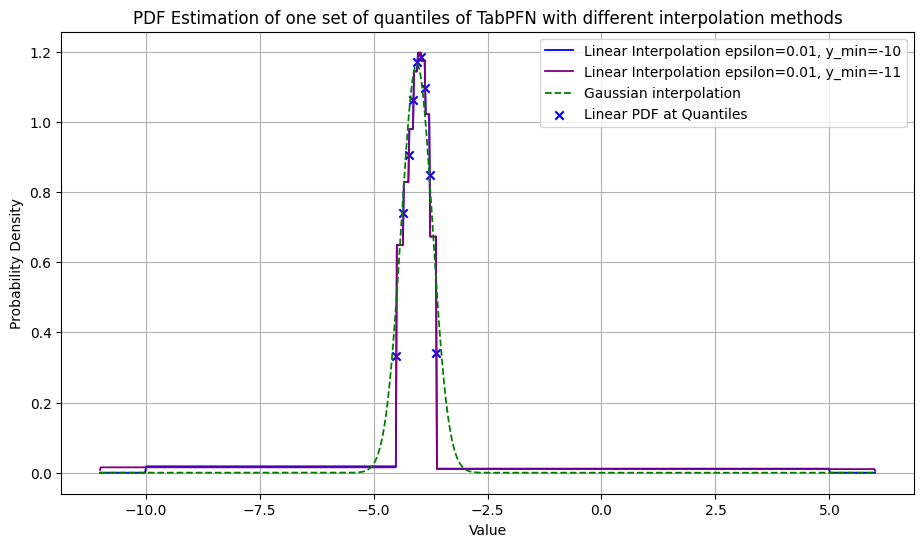

---


<Figure size 1100x600 with 0 Axes>

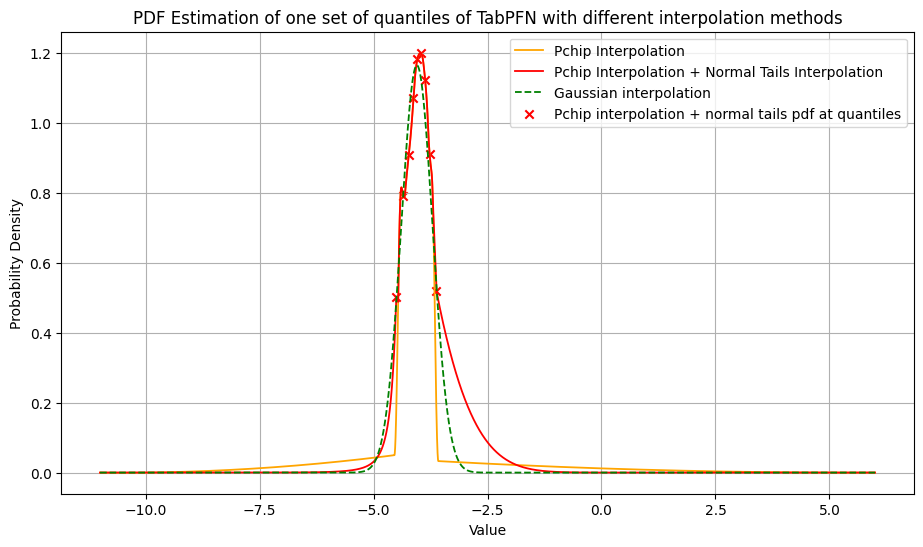

In [14]:
plot_cdf_pdf_dynamic(all_quantiles_2[:,70], probabilities, -10, 5, case=2, 
                     mu_left_asym=mu_left_asym, sigma_left_asym=sigma_left_asym, 
                     mu_right_asym=mu_right_asym, sigma_right_asym=sigma_right_asym)
print("---")
plot_cdf_pdf_dynamic(all_quantiles_2[:,70], probabilities, -10, 5, case=3, 
                     mu_left_asym=mu_left_asym, sigma_left_asym=sigma_left_asym, 
                     mu_right_asym=mu_right_asym, sigma_right_asym=sigma_right_asym)


In [ ]:
qtl = all_quantiles_2[:, 200]
print(qtl)
print(qtl[-2:])
print(qtl[-1])

In [ ]:
pd.DataFrame(borders_new_2)

In [ ]:
pd.DataFrame(logits_2)

In [ ]:
pd.DataFrame(probs_t).round(10)

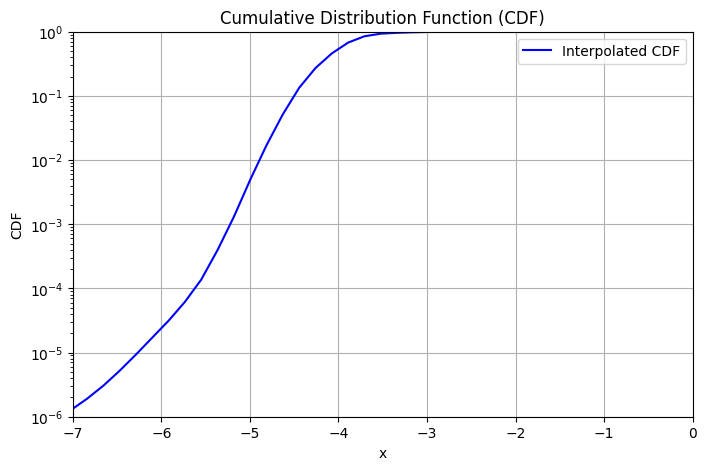

In [ ]:
import scipy.interpolate as spi

# Assuming logits_2 is a tensor of shape (N, 5000)
probs_t = torch.softmax(logits_2, dim=1)  # (N, 5000)
probs_np = probs_t[70, :].cpu().numpy()  # Convert to NumPy (1D array)

# Compute CDF
cdf_values_t = np.cumsum(probs_np)
cdf_values_t /= cdf_values_t[-1]  # Normalize to [0, 1]

# Convert borders to NumPy if necessary
borders_np = borders_new_2.cpu().numpy() if isinstance(borders_new_2, torch.Tensor) else np.array(borders_new_2)

# Create an interpolation function
cdf_function_t = spi.interp1d(
    borders_np[:-1], cdf_values_t, kind='linear', fill_value=(0, 1), bounds_error=False
)

# Generate x values for plotting
x_plot = np.linspace(borders_np[0], borders_np[-1], 1000)  # Smooth x range
y_plot = cdf_function_t(x_plot)  # Evaluate the CDF function

# Plot the CDF
plt.figure(figsize=(8, 5))
plt.plot(x_plot, y_plot, label="Interpolated CDF", color="blue")
#plt.scatter(borders_np[:-1], cdf_values_t, color="red", s=5, label="Original CDF Points")  # Show original data
plt.xlabel("x")
plt.yscale("log")
plt.ylabel("CDF")
plt.xlim(-7,0)
plt.ylim(1e-6, 1)
plt.title("Cumulative Distribution Function (CDF)")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
borders_np

array([-97.104225, -28.661531, -25.083885, ...,  22.27344 ,  25.810175,
        86.92629 ], dtype=float32)

In [44]:
midpoints.shape

(5000,)

In [40]:
(-97.104225 - 28.66153)/2

-62.8828775

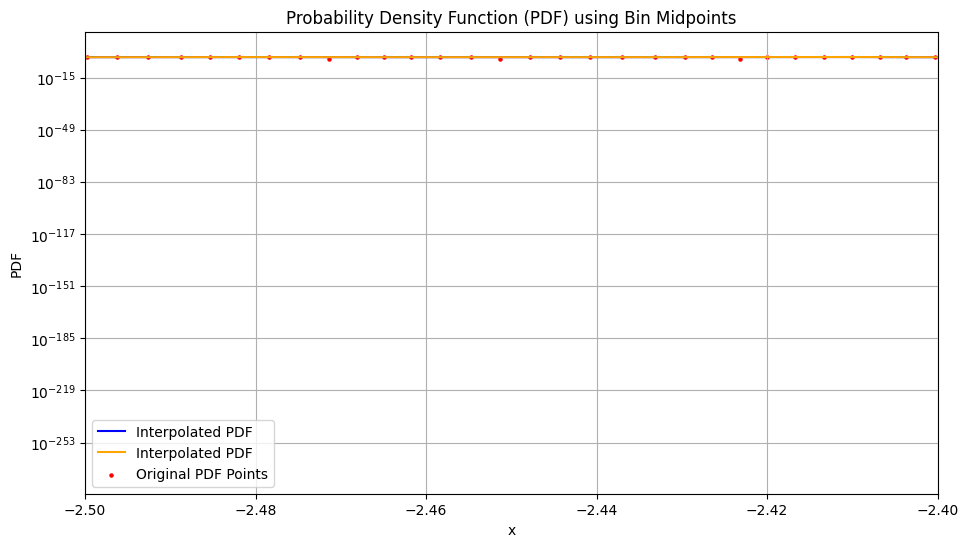

In [20]:
import torch
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt

id_test = 0

# Assuming logits_2 is a tensor of shape (N, 5000)
probs_t = torch.softmax(logits_2, dim=1)  # Convert logits to probabilities (N, 5000)
probs_np = probs_t[id_test, :].cpu().numpy()  # Convert first sample to NumPy (1D array)

# Convert bin borders to NumPy if necessary
borders_np = borders_new_2.cpu().numpy() if isinstance(borders_new_2, torch.Tensor) else np.array(borders_new_2)

# Compute bin widths (size 5000)
bin_widths = np.diff(borders_np)  # Difference between consecutive bin edges

# Compute PDF values (divide probability mass by bin width)
pdf_values = probs_np / bin_widths  # Element-wise division

# Compute bin midpoints
midpoints = (borders_np[:-1] + borders_np[1:]) / 2  # Midpoints of bins

# Create an interpolation function using midpoints
pdf_function_linear = spi.interp1d(
    midpoints, pdf_values, kind='linear', fill_value="extrapolate", bounds_error=False
)

pdf_function_pchip = spi.CubicSpline(
    midpoints, pdf_values, extrapolate=True)



# Generate x values for plotting
x_plot = np.linspace(midpoints[0], midpoints[-1], 5000)  # Smooth x range
y_plot = pdf_function_pchip(x_plot)  # Evaluate the PDF function
y_plot_2 = pdf_function_linear(x_plot)  # Evaluate the PDF function
# Plot the PDF
plt.figure(figsize=(11, 6))
plt.plot(x_plot, y_plot, label="Interpolated PDF", color="blue")
plt.plot(x_plot, y_plot_2, label="Interpolated PDF", color="orange")
plt.scatter(midpoints, pdf_values, color="red", s=5, label="Original PDF Points")  # Show original data
plt.xlabel("x")
plt.yscale("log")
plt.xlim(-2.5, -2.4)
plt.ylabel("PDF")
plt.title("Probability Density Function (PDF) using Bin Midpoints")
plt.legend()
plt.grid(True)
plt.show()




In [28]:
pd.DataFrame(all_quantiles_2)

,0,1,2,3,4,5,6,7,8,9,...,8726,8727,8728,8729,8730,8731,8732,8733,8734,8735
0,-3.576945,-3.626749,-3.632998,-3.614438,-3.565285,-3.570307,-3.604372,-3.743188,-3.882826,-3.929623,...,-3.479660,-3.493698,-3.581400,-3.533027,-3.485861,-3.490684,-3.500721,-3.433422,-3.157633,-3.168751
1,-3.079643,-3.519547,-3.550858,-3.523435,-3.463683,-3.439502,-3.439538,-3.590272,-3.739456,-3.755694,...,-3.348362,-3.377480,-3.472180,-3.418994,-3.366662,-3.364808,-3.360674,-3.205817,-2.923996,-3.023911
2,-1.989095,-3.297117,-3.470342,-3.447085,-3.388504,-3.335644,-3.316018,-3.435700,-3.602491,-3.560717,...,-3.243241,-3.284260,-3.388648,-3.325822,-3.272919,-3.264131,-3.245125,-3.078069,-2.838772,-2.898823
3,-1.820700,-2.400714,-3.365960,-3.374676,-3.311787,-3.256058,-3.233913,-3.307260,-3.464403,-3.392138,...,-3.170904,-3.221724,-3.307664,-3.254517,-3.213295,-3.196419,-3.170427,-2.972417,-2.784058,-2.810846
4,-1.808237,-1.939098,-3.095030,-3.259101,-3.234412,-3.198731,-3.178200,-3.217835,-3.319279,-3.233455,...,-3.099299,-3.158567,-3.234207,-3.195295,-3.148577,-3.127067,-3.101711,-2.863435,-2.721523,-2.711754
5,-1.800912,-1.818094,-2.105540,-3.035278,-3.109379,-3.126149,-3.124353,-3.156888,-3.196761,-3.144667,...,-3.022451,-3.049327,-3.139284,-3.094718,-3.045728,-3.039771,-3.030470,-2.774055,-2.623703,-2.578736
6,-1.794722,-1.804178,-1.979954,-2.100842,-2.414909,-2.962245,-3.035784,-3.086350,-3.113501,-3.069064,...,-2.880010,-2.502325,-2.772727,-2.669883,-2.559597,-2.838144,-2.912698,-2.573349,-2.488540,-2.438612
7,-1.788871,-1.794972,-1.817210,-1.996427,-2.085176,-2.179004,-2.356638,-2.800825,-2.954860,-2.709055,...,-2.203569,-2.151864,-2.116633,-2.141295,-2.158312,-2.179538,-2.257787,-2.364200,-2.297514,-2.276276
8,-1.779476,-1.784348,-1.795255,-1.813535,-1.895409,-2.114398,-2.167238,-2.236863,-2.331258,-2.394596,...,-2.132961,-2.104714,-2.016055,-2.082161,-2.111128,-2.127196,-2.142717,-2.131463,-2.143870,-2.195429


In [29]:
pd.DataFrame(all_quantiles_2[:,0])

,0
0,-3.576945
1,-3.079643
2,-1.989095
3,-1.820700
4,-1.808237
5,-1.800912
6,-1.794722
7,-1.788871
8,-1.779476


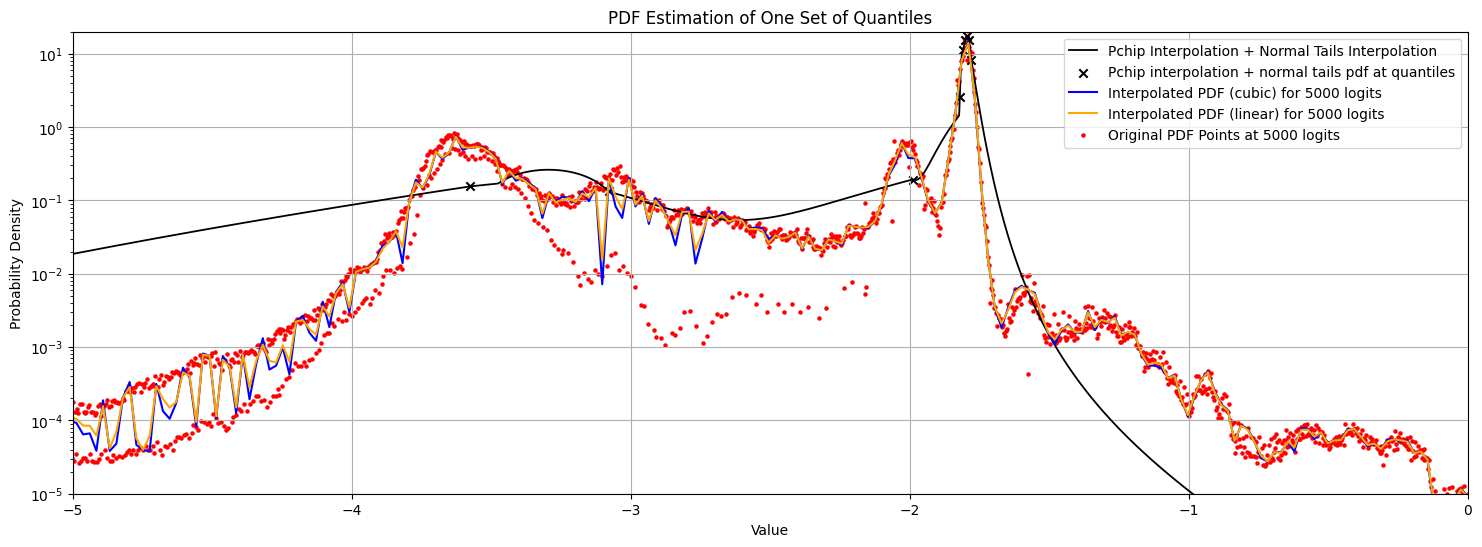

<Figure size 1100x600 with 0 Axes>

In [93]:
id = 0

#x_lim = (-2.1, -1.5)
#x_lim = (-1.85, -1.75)  
#x_lim = (-2.5, -1.5)  
x_lim = (-5, 0)
y_lim = (1e-5, 20)  # Adjust as needed for log-scale compatibility
scale = "log"
#scale = "linear"
fig, ax = plt.subplots(figsize=(18, 6))

probabilities = quantiles_custom
yt = entsoe["power"]
quantile_10 = np.percentile(yt, probabilities * 100)


# Fit left and right tails
mu_left_asym, sigma_left_asym = fit_tail_distribution(quantile_10[:2], probabilities[:2])
mu_right_asym, sigma_right_asym = fit_tail_distribution(quantile_10[-2:], probabilities[-2:])

plot_cdf_pdf_dynamic(ax, all_quantiles_2[:,id], probabilities, -10, 5, x_lim, y_lim, log_scale=scale, case=3, 
                     mu_left_asym=mu_left_asym, sigma_left_asym=sigma_left_asym, 
                     mu_right_asym=mu_right_asym, sigma_right_asym=sigma_right_asym)
plot_pdf_from_logits(ax, logits_2, borders_new_2, x_lim, y_lim, log_scale=scale, id=id)

plt.show()

In [23]:
plot_elements_case3.show()

AttributeError: 'list' object has no attribute 'show'